![](img/330-banner.png)

# Lecture 11: Ensembles

UBC 2023 Summer

Instructor: Mehrdad Oveisi

<blockquote>
The interests of truth require a diversity of opinions.    
    
by John Stuart Mill
</blockquote>



## Imports

In [1]:
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("code/.")

from plotting_functions import *
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from utils import *

## Lecture learning objectives

From this lecture, you will be able to 

- Use `scikit-learn`'s `RandomForestClassifier` and explain its main hyperparameters. 
- Explain randomness in random forest algorithm. 
- Use other tree-based models such as `XGBoost` and `LGBM`.
- Employ ensemble classifier approaches, in particular model averaging and stacking.
- Explain voting and stacking and the differences between them.
- Use `scikit-learn` implementations of these ensemble methods.

## Motivation

- **Ensembles** are models that combine multiple machine learning models to create more powerful models. 

### The Netflix prize

<!-- ![](img/netflix.png) -->

<img src="img/netflix.png" width="700">

[Source](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)

- Most of the winning solutions for Kaggle competitions involve some kind of ensembling. For example: 

<!-- ![](img/fraud_detection_kaggle.png) -->

<img src="img/fraud_detection_kaggle.png" width="400">


Key idea: Groups can often make better decisions than individuals, especially when group members are diverse enough. 

[The Wisdom of Crowds](http://wisdomofcrowds.blogspot.com/2009/12/introduction-part-i.html)

![](img/wisdom_of_crowds.jpg)

<!-- <img src="img/wisdom_of_crowds.jpg" width="300" height="300"> -->


### Tree-based ensemble models 
- A number of ensemble models in ML literature.
- Most successful ones on a variety of datasets are tree-based models. 
- We'll briefly talk about two such models: 
    - **Random forests**
    - **Gradient boosted trees**
- We'll also talk about averaging and stacking. 

### Tree-based models 

- Decision trees models are
    - **Interpretable**
    - They can capture **non-linear** relationships
    - They **do not** require **scaling** of the data and theoretically can work with **categorical** features
- But with a single decision trees are likely to **overfit**.

- Key idea: **Combine multiple trees** to build stronger models.
- These kinds of models are extremely popular in industry and machine learning competitions  

### Data

- Let's work with [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income).

In [2]:
adult_df_large = pd.read_csv("data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States,<=50K
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,<=50K
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [3]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["race", "education.num"]
target_column = "income"

In [4]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [5]:
assert set(education_levels) == set(train_df["education"].unique())

In [6]:
numeric_transformer = make_pipeline(StandardScaler())

ordinal_transformer = make_pipeline(
    OrdinalEncoder(categories=[education_levels], dtype=int)
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [7]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

### Do we have class imbalance? 

- There is class imbalance. But without any context, both classes seem equally important. 
- Let's use accuracy as our metric. 

In [8]:
train_df_nan["income"].value_counts(normalize=True)

<=50K    0.757985
>50K     0.242015
Name: income, dtype: float64

In [9]:
scoring_metric = "accuracy"

Let's store all the results in a dictionary called `results`. 

In [10]:
results = {}

### Baselines

####  `DummyClassifier` baseline

In [11]:
dummy = DummyClassifier(strategy="most_frequent")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

#### `DecisionTreeClassifier` baseline

- Let's try decision tree classifier on our data. 

In [12]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
results["Decision tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.017 (+/- 0.013),0.008 (+/- 0.002),0.758 (+/- 0.000),0.758 (+/- 0.000)
Decision tree,0.335 (+/- 0.050),0.033 (+/- 0.005),0.813 (+/- 0.003),1.000 (+/- 0.000)


Decision tree is clearly **overfitting**.

<br><br><br><br>

## Random forests 

### General idea

- A single decision tree is likely to overfit
- Use a **collection of diverse** decision trees
- Each tree overfits on some part of the data but we can reduce overfitting by averaging the results 
    - can be shown mathematically

### `RandomForestClassifier` 

- Before understanding the details let's first try it out.  

In [13]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=123, n_jobs=-1)
)
results["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.017 (+/- 0.013),0.008 (+/- 0.002),0.758 (+/- 0.000),0.758 (+/- 0.000)
Decision tree,0.335 (+/- 0.050),0.033 (+/- 0.005),0.813 (+/- 0.003),1.000 (+/- 0.000)
Random forests,3.533 (+/- 2.196),0.186 (+/- 0.024),0.857 (+/- 0.004),1.000 (+/- 0.000)


The validation scores are better although it seems likes we are still overfitting. 

### How do they work? 

- Decide how many decision trees we want to build
    - can control with `n_estimators` hyperparameter 
- `fit` a **diverse set** of that many decision trees by **injecting randomness** in the classifier construction
- `predict` by **voting** (classification) or **averaging** (regression) of predictions given by individual models

### Inject randomness in the classifier construction

To ensure that the trees in the random forest are different we inject randomness in two ways:  

1. Data: **Build each tree on a bootstrap sample** (i.e., a sample drawn **with replacement** from the training set)
2. Features: **At each node, select a random subset of features** (controlled by `max_features` in `scikit-learn`) and look for the best possible test involving one of these features   

An example of a bootstrap samples
Suppose this is your original dataset: [1,2,3,4]
- a sample drawn with replacement: [1,1,3,4]
- a sample drawn with replacement: [3,2,2,2]
- a sample drawn with replacement: [1,2,4,4]
- ...

***See Also*** (Optional) 
> There is also something called [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), where we add more randomness by consider a random subset of features at each split and **random threshold**.

### The random forests classifier 

***Training time***:
- Create a collection (**ensemble**) of trees.
    - Grow each tree on an independent **bootstrap sample from the data**.
- At each node:
    - Randomly select a **subset of features** out of all features (independently for each node).
    - Find the **best split** on the selected features.
    - Grow the trees to **maximum depth**.

***Prediction time***:
- **Vote** the trees to get predictions for new example.

### Example 

- Let's create a random forest with 3 estimators. 
- I'm using `max_depth=2` for easy visualization. 

In [14]:
pipe_rf_demo = make_pipeline(
    preprocessor, RandomForestClassifier(max_depth=2, n_estimators=3, random_state=123)
)
pipe_rf_demo.fit(X_train, y_train);

- Let's get the feature names of transformed features.

In [15]:
feature_names = (
    numeric_features
    + ordinal_features
    + binary_features
    + list(
        pipe_rf_demo.named_steps["columntransformer"]
        .named_transformers_["pipeline-4"]
        .named_steps["onehotencoder"]
        .get_feature_names_out()
    )
)
pd.DataFrame(columns=feature_names)  # Take a look at the feature names

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,education,sex,x0_Federal-gov,x0_Local-gov,x0_Never-worked,...,x4_Puerto-Rico,x4_Scotland,x4_South,x4_Taiwan,x4_Thailand,x4_Trinadad&Tobago,x4_United-States,x4_Vietnam,x4_Yugoslavia,x4_missing


- Let's sample a test example.

In [16]:
test_example = X_test.sample(1)
print("Classes: ", pipe_rf_demo.classes_)
print("Prediction by random forest: ", pipe_rf_demo.predict(test_example))
transformed_example = preprocessor.transform(test_example)
pd.DataFrame(transformed_example, columns=feature_names)

Classes:  ['<=50K' '>50K']
Prediction by random forest:  ['<=50K']


,age,fnlwgt,capital.gain,capital.loss,hours.per.week,education,sex,x0_Federal-gov,x0_Local-gov,x0_Never-worked,...,x4_Puerto-Rico,x4_Scotland,x4_South,x4_Taiwan,x4_Thailand,x4_Trinadad&Tobago,x4_United-States,x4_Vietnam,x4_Yugoslavia,x4_missing
0,-0.627563,1.488091,0.519592,-0.21768,0.363354,11.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


- We can look at **different trees** created by random forest. 
- Note that each tree looks at **different set of features** and slightly **different data**.



Tree 1


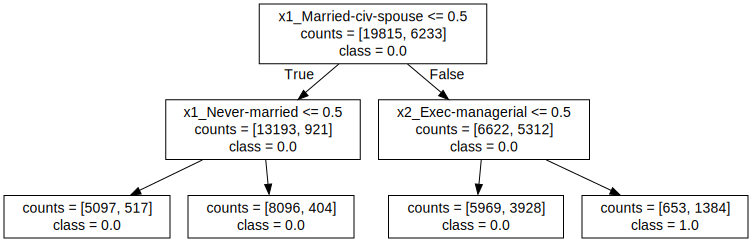


Prediction: [0.]


Tree 2


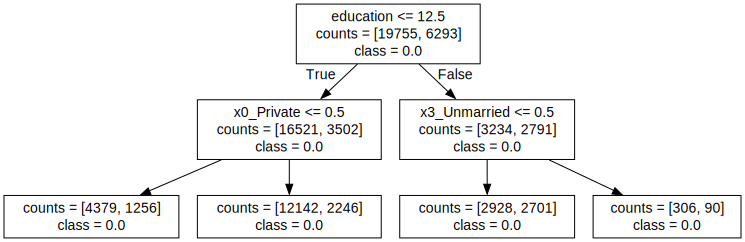


Prediction: [0.]


Tree 3


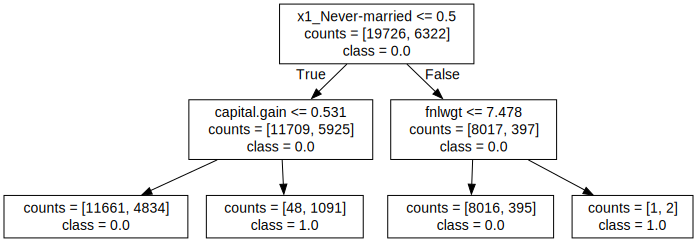


Prediction: [0.]


In [17]:
for i, tree in enumerate(
    pipe_rf_demo.named_steps["randomforestclassifier"].estimators_
):
    print("\n\nTree", i + 1)
    display(display_tree(feature_names, tree, counts=True))
    print("\nPrediction:", tree.predict(preprocessor.transform(test_example)))

### Some important hyperparameters:

- `n_estimators`: number of decision trees (higher = more complexity)
- `max_depth`: max depth of each decision tree (higher = more complexity)
- `max_features`: the number of features you get to look at each split (higher = more complexity)


### Random forests: number of trees (`n_estimators`) and the fundamental tradeoff 

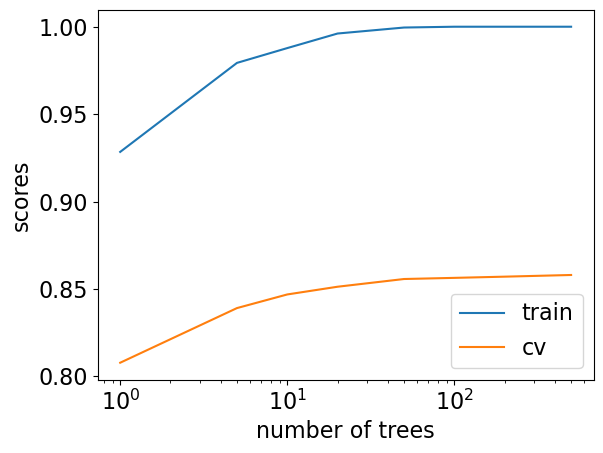

In [18]:
make_num_tree_plot(
    preprocessor, X_train, y_train, X_test, y_test, [1, 5, 10, 20, 50, 100, 200, 500]
)

#### Number of trees and fundamental trade-off

- Above: seems like we're beating the fundamental "tradeoff" by <br>**increasing training score** and **not decreasing validation score** much.
- This is the promise of ensembles, though it's not guaranteed to work so nicely.

**More trees are always better!** We pick less trees for speed. 


### Strengths

- Usually **one of the best** performing **off-the-shelf** classifiers without heavy tuning of hyperparameters
- **Don't** require **scaling** of data 
- **Less** likely to **overfit**
- Slower than decision trees because we are fitting multiple trees but <br>**can easily parallelize training** because all trees are independent of each other
- In general, able to capture a much broader picture of the data compared to a single decision tree. 

### Weaknesses

- Require more memory 
- Hard to interpret
- Tend not to perform well on high dimensional sparse data such as text data


***Important***
> Make sure to set the `random_state` for reproducibility. Changing the `random_state` can have a big impact on the model and the results due to the random nature of these models. Having more trees can get you a more robust estimate.

***See Also*** (Optional)
> [The original random forests paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) by Leo Breiman.

<br><br>

## ❓❓ Questions for you

iClicker join links

- CPSC 330 **911**
  - https://join.iclicker.com/LFDB
- CPSC 330 **912**
  - https://join.iclicker.com/GJMY

### iClicker Exercise 11.1 

**Select all of the following statements which are TRUE.**

- (A) Every tree in a random forest uses a different bootstrap sample of the training set.
- (B) To train a tree in a random forest, we first randomly select a subset of features. The tree is then restricted to only using those features.
- (C) A reasonable implementation of `predict_proba` for random forests would be for each tree to "vote" and then normalize these vote counts into probabilities.
- (D) Increasing the hyperparameter max_features (the number of features to consider for a split) makes the model more complex and moves the fundamental tradeoff toward lower training error. 
- (E) A random forest with only one tree is likely to get a higher training error than a decision tree of the same depth.

<br><br>

How would you carry out "soft voting" with `predict_proba` output instead of hard voting for random forests? 

<br><br><br><br>

## Gradient boosted trees 

Another popular and effective class of tree-based models is gradient boosted trees. 

- **No** randomization
- The key idea is:<br>combining many simple models called **weak learners to create a strong learner**
- They combine **multiple shallow** (depth 1 to 5) decision trees
- They build trees in a **serial manner**, where each tree tries to **correct the mistakes** of the previous one

### Important hyperparameters

- `n_estimators`
    - control the number of trees to build
- `learning_rate`
    - controls **how strongly** each tree tries to **correct the mistakes** of the previous trees
    - **higher** `learning_rate` 
      - means each tree can make **stronger corrections**, 
      - which means **more complex** model

We'll not go into the details. We'll look at brief examples of using the following three gradient boosted tree models. 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/)
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)
- [CatBoost](https://catboost.ai/docs/concepts/python-quickstart.html)

### [XGBoost](https://xgboost.ai/about)

- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment: <br> `conda install -n cpsc330 -c conda-forge xgboost`
- Supports missing values
- GPU training, networked parallel training
- Supports sparse data
- Typically better scores than random forests

### [LightGBM](https://lightgbm.readthedocs.io/)

- Not part of `sklearn` but has similar interface.
- Install it in your conda environment: <br> `conda install -n cpsc330 -c conda-forge lightgbm`
- Small model size
- Faster
- Typically better scores than random forests

### [CatBoost](https://catboost.ai/)

- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment: <br> `conda install -n cpsc330 -c conda-forge catboost`
- Usually **better scores but slower** compared to `XGBoost` and `LightGBM`     

In [19]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [20]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, random_state=123)
)
classifiers = {
    "logistic regression": pipe_lr,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    #"XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

In [21]:
results = {}

In [22]:
dummy = DummyClassifier(strategy="most_frequent")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [23]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [24]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.011 (+/- 0.001),0.008 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
logistic regression,6.716 (+/- 1.580),0.135 (+/- 0.014),0.850 (+/- 0.006),0.851 (+/- 0.001)
decision tree,0.320 (+/- 0.019),0.033 (+/- 0.008),0.813 (+/- 0.003),1.000 (+/- 0.000)
random forest,3.156 (+/- 1.369),0.170 (+/- 0.031),0.857 (+/- 0.004),1.000 (+/- 0.000)
LightGBM,0.317 (+/- 0.015),0.051 (+/- 0.012),0.871 (+/- 0.004),0.892 (+/- 0.000)
CatBoost,9.396 (+/- 1.601),0.191 (+/- 0.022),0.872 (+/- 0.003),0.900 (+/- 0.001)


**Some observations**
- Keep in mind all these results are with default hyperparameters
- **Ideally** we would carry out **hyperparameter optimization** for all of them and then compare the results. 
- We are using a particular scoring metric (accuracy in this case)
- We are scaling numeric features but it shouldn't matter for these tree-based models. 
- Look at the **std. Doesn't look very high**. 
    - The scores look more or less stable. 

In [25]:
pd.DataFrame(results).T.sort_values('test_score')

,fit_time,score_time,test_score,train_score
Dummy,0.011 (+/- 0.001),0.008 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
decision tree,0.320 (+/- 0.019),0.033 (+/- 0.008),0.813 (+/- 0.003),1.000 (+/- 0.000)
logistic regression,6.716 (+/- 1.580),0.135 (+/- 0.014),0.850 (+/- 0.006),0.851 (+/- 0.001)
random forest,3.156 (+/- 1.369),0.170 (+/- 0.031),0.857 (+/- 0.004),1.000 (+/- 0.000)
LightGBM,0.317 (+/- 0.015),0.051 (+/- 0.012),0.871 (+/- 0.004),0.892 (+/- 0.000)
CatBoost,9.396 (+/- 1.601),0.191 (+/- 0.022),0.872 (+/- 0.003),0.900 (+/- 0.001)


In [26]:
# comparison of results (excluding the the 'Dummy' row [1:])

cv_score_order = pd.DataFrame(results).T[1:].sort_values('test_score').index
print('\nCV scores:')
print(*cv_score_order, sep=' < ')

fit_time_order = pd.DataFrame(results).T[1:].sort_values('fit_time').index
print('\nFitting speeds:')
print(*fit_time_order, sep=' > ')


CV scores:
decision tree < logistic regression < random forest < LightGBM < CatBoost

Fitting speeds:
LightGBM > decision tree > random forest > logistic regression > CatBoost


- Decision trees and random forests overfit
    - Other models do not seem to overfit much. 
- Fit times
    - Decision trees are fast but not very accurate
    - LightGBM is faster than decision trees and more accurate! 
    - CatBoost fit time is highest followed by random forests.  
    - There is not much difference between the validation scores of XGBoost, LightGBM, and CatBoost but it is about 48x slower than LightGBM!
    - XGBoost and LightGBM are faster and more accurate than random forest!    
- Scores times  
    - Prediction times are much smaller in all cases. 

### What classifier should I use?

**Simple answer**
- Whichever gets the highest CV score making sure that you're not overusing the validation set.

**Interpretability**
- This is an area of growing interest and concern in ML.
- How important is interpretability for you? 
- In the next class we'll talk about interpretability of non-linear models. 

**Speed/code maintenance**
- Other considerations could be speed (fit and/or predict), maintainability of the code.

Finally, you could use all of them!

<br><br><br><br>

## Averaging 

Earlier we looked at a bunch of classifiers:

In [27]:
classifiers.keys()

dict_keys(['logistic regression', 'decision tree', 'random forest', 'LightGBM', 'CatBoost'])

Or using Python's *unpacking* feature (see [lecture 8](./08_hyperparameter-optimization.ipynb)):

In [28]:
print(*classifiers, sep=', ')

logistic regression, decision tree, random forest, LightGBM, CatBoost


What if we use all these models and let them vote during prediction time? 

In [29]:
from sklearn.ensemble import VotingClassifier

averaging_model = VotingClassifier(
    list(classifiers.items()), voting="soft"
)  # need the list() here for cross_val to work!

In [30]:
from sklearn import set_config

set_config(display="diagram")  # global setting

In [31]:
averaging_model

VotingClassifier(estimators=[('logistic regression',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                Pipeline(steps=[('standardscaler',
                                                                                                 StandardScaler())]),
                                                                                ['age',
                                                                                 'fnlwgt',
                                                                                 'capital.gain',
                                                                                 'capital.loss',
                                                                                 'hours.per.week']),
                                                                               ('pipeline-2',
                                                                                Pipeline(steps=[('ordinalencoder',
                                                                                                 OrdinalEncoder(categories=[['Preschool',
                                                                                                                             '1st-4th'...
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(fill_value='missing',
                                                                                                               strategy='constant')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['workclass',
                                                                                 'marital.status',
                                                                                 'occupation',
                                                                                 'relationship',
                                                                                 'native.country']),
                                                                               ('drop',
                                                                                'drop',
                                                                                ['race',
                                                                                 'education.num'])])),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x7f16f8c1d750>)]))],
                 voting='soft')

This `VotingClassifier` will take a _vote_ using the predictions of the constituent classifier pipelines.

Main parameter: `voting`
- `voting='hard'` 
    - it uses the output of `predict` and actually votes.
- `voting='soft'`
    - with `voting='soft'` it **averages the output** of `predict_proba` and then thresholds / takes the larger.

- The choice depends on whether you trust `predict_proba` from your base classifiers - if so, it's nice to access that information.

In [32]:
averaging_model.fit(X_train, y_train);

- What happens when you `fit` a `VotingClassifier`?
    - It will fit all constituent models.    

***Note***
> It seems sklearn requires us to actually call `fit` on the `VotingClassifier`, instead of passing in pre-fit models. This is an implementation choice rather than a conceptual limitation.

Let's look at particular test examples where `income` is ">50k" (y=1):

In [33]:
test_g50k = (test_df.query("income == '>50K'")
            .sample(4, random_state=2)
            .drop(columns=["income"]))

test_l50k = (test_df.query("income == '<=50K'")
            .sample(4, random_state=2)
            .drop(columns=["income"]))

In [34]:
averaging_model.classes_

array(['<=50K', '>50K'], dtype=object)

In [35]:
voting = {"Voting classifier": averaging_model.predict(test_l50k)}
pd.DataFrame(voting)

,Voting classifier
0,<=50K
1,<=50K
2,<=50K
3,<=50K


For hard voting, these are the votes:

In [36]:
hard = {
    name: classifier.predict(test_l50k)
    for name, classifier in averaging_model.named_estimators_.items()
}
hard.update(voting)
pd.DataFrame(hard)

,logistic regression,decision tree,random forest,LightGBM,CatBoost,Voting classifier
0,0,0,0,0,0,<=50K
1,0,0,0,0,0,<=50K
2,0,0,0,0,0,<=50K
3,0,1,0,0,0,<=50K


For soft voting, these are the scores:

In [37]:
soft = {
    name: classifier.predict_proba(test_l50k)[:,1]
    for name, classifier in averaging_model.named_estimators_.items()
}
soft.update(voting)
pd.DataFrame(soft)

,logistic regression,decision tree,random forest,LightGBM,CatBoost,Voting classifier
0,0.038327,0.0,0.11,0.001161,0.006237,<=50K
1,0.036044,0.0,0.02,0.024104,0.021504,<=50K
2,0.028914,0.0,0.01,0.018838,0.035919,<=50K
3,0.323530,1.0,0.38,0.419239,0.258217,<=50K


(Aside: the probability scores from `DecisionTreeClassifier` are pretty bad)

Let's see how well this model performs.

In [38]:
results["Voting"] = mean_std_cross_val_scores(averaging_model, X_train, y_train)

In [39]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.011 (+/- 0.001),0.008 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
logistic regression,6.716 (+/- 1.580),0.135 (+/- 0.014),0.850 (+/- 0.006),0.851 (+/- 0.001)
decision tree,0.320 (+/- 0.019),0.033 (+/- 0.008),0.813 (+/- 0.003),1.000 (+/- 0.000)
random forest,3.156 (+/- 1.369),0.170 (+/- 0.031),0.857 (+/- 0.004),1.000 (+/- 0.000)
LightGBM,0.317 (+/- 0.015),0.051 (+/- 0.012),0.871 (+/- 0.004),0.892 (+/- 0.000)
CatBoost,9.396 (+/- 1.601),0.191 (+/- 0.022),0.872 (+/- 0.003),0.900 (+/- 0.001)
Voting,19.377 (+/- 6.470),0.653 (+/- 0.129),0.864 (+/- 0.004),NaN


It appears that here we didn't do much better than our best classifier :(

Let's try removing decision tree classifier. 

In [40]:
classifiers_ndt = classifiers.copy()
del classifiers_ndt["decision tree"]
averaging_model_ndt = VotingClassifier(
    list(classifiers_ndt.items()), voting="soft"
)  # need the list() here for cross_val to work!

results["Voting_ndt"] = mean_std_cross_val_scores(
    averaging_model_ndt,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)

In [41]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.011 (+/- 0.001),0.008 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
logistic regression,6.716 (+/- 1.580),0.135 (+/- 0.014),0.850 (+/- 0.006),0.851 (+/- 0.001)
decision tree,0.320 (+/- 0.019),0.033 (+/- 0.008),0.813 (+/- 0.003),1.000 (+/- 0.000)
random forest,3.156 (+/- 1.369),0.170 (+/- 0.031),0.857 (+/- 0.004),1.000 (+/- 0.000)
LightGBM,0.317 (+/- 0.015),0.051 (+/- 0.012),0.871 (+/- 0.004),0.892 (+/- 0.000)
CatBoost,9.396 (+/- 1.601),0.191 (+/- 0.022),0.872 (+/- 0.003),0.900 (+/- 0.001)
Voting,19.377 (+/- 6.470),0.653 (+/- 0.129),0.864 (+/- 0.004),NaN
Voting_ndt,20.241 (+/- 4.767),0.810 (+/- 0.524),0.871 (+/- 0.003),0.924 (+/- 0.001)


Still the results are not better than the best performing model. 

### Why combine estimators?

- It didn't happen here but how could the average do better than the best model???
  - From the perspective of the best estimator (in this case CatBoost), why are you adding on worse estimators??


Here's how this can work:

| Example | log reg    | rand forest    | cat boost    | Averaged model |
|--------|--------|--------|---------|---------------|
|  1     | ✅    |   ✅    | ❌     | ✅✅❌=>✅  |
|  2     | ✅    |   ❌    | ✅     | ✅❌✅=>✅  |
|  3     | ❌    |   ✅    | ✅     | ❌✅✅=>✅  |


In short, as long as the different models make **different mistakes**, this can work.

### Why not always do this?

1. `fit`/`predict` **time**.
2. Reduction in **interpretability**.
3. Reduction in code **maintainability** (e.g. Netflix prize).

### What kind of estimators can we combine?

- You can **combine**
    - completely different estimators, or similar estimators.
    - estimators trained on **different samples**.
    - estimators with **different hyperparameter** values.

<br><br><br><br>

## Stacking 

- Another **type of ensemble** is stacking.
- Instead of averaging the outputs of each estimator, <br>use their **outputs as inputs** to another ***model***.
- By default for classification, it uses **logistic regression**.
  - We don't need a complex model here necessarily, more of a weighted average.
  - The features going into the logistic regression are the classifier outputs, _not_ the original features!
  - So the number of coefficients = the number of base estimators!

In [42]:
from sklearn.ensemble import StackingClassifier

The code starts to get **too slow** here; so we'll remove CatBoost.

In [43]:
classifiers_nocat = classifiers.copy()
del classifiers_nocat["CatBoost"]

In [44]:
stacking_model = StackingClassifier(list(classifiers_nocat.items()))

In [45]:
stacking_model.fit(X_train, y_train);

What's going on in here? 

- It is doing cross-validation by itself by default (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html))
  - It is fitting the base estimators on the training fold
  - And the predicting on the validation fold
  - And then fitting the meta-estimator on that output (on the validation fold)

> Note that `estimators_` are fitted on the full X while `final_estimator_` is trained using cross-validated predictions of the base estimators using `cross_val_predict`.

Here is the input features (X) to the meta-model:

In [46]:
X_valid_sample = X_train.sample(4, random_state=2)
y_valid_sample = y_train[X_valid_sample.index]

In [47]:
stacking = {
    name: pipe.predict_proba(X_valid_sample)[:, 1]
    for (name, pipe) in stacking_model.named_estimators_.items()
}
stacking.update(y_valid_sample.to_frame().to_dict('list'))
pd.DataFrame(stacking)

,logistic regression,decision tree,random forest,LightGBM,income
0,0.566514,0.0,0.12,0.433701,<=50K
1,0.000980,0.0,0.00,0.006493,<=50K
2,0.140379,0.0,0.05,0.080048,<=50K
3,0.004727,0.0,0.00,0.003702,<=50K


- Our meta-model is logistic regression (which it is by default).
- Let's look at the learned coefficients. 

In [48]:
pd.DataFrame(
    data=stacking_model.final_estimator_.coef_[0],
    index=classifiers_nocat.keys(),
    columns=["Coefficient"],
)

,Coefficient
logistic regression,0.725974
decision tree,-0.000645
random forest,0.373050
LightGBM,5.584762


In [49]:
stacking_model.final_estimator_.intercept_

array([-3.32126431])

- It seems that the LightGBM is being trusted the most. 

In [50]:
stacking_model.predict(test_g50k)

array(['>50K', '>50K', '>50K', '<=50K'], dtype=object)

In [51]:
stacking_model.predict_proba(test_g50k)

array([[0.03384946, 0.96615054],
       [0.20781847, 0.79218153],
       [0.2184713 , 0.7815287 ],
       [0.8824213 , 0.1175787 ]])

In [52]:
stacking_model.predict_proba(test_g50k)[:,1]

array([0.96615054, 0.79218153, 0.7815287 , 0.1175787 ])

(This is the `predict_proba` from logistic regression)

Let's see how well this model performs.

In [53]:
results["Stacking_nocat"] = mean_std_cross_val_scores(
    stacking_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [54]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.011 (+/- 0.001),0.008 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
logistic regression,6.716 (+/- 1.580),0.135 (+/- 0.014),0.850 (+/- 0.006),0.851 (+/- 0.001)
decision tree,0.320 (+/- 0.019),0.033 (+/- 0.008),0.813 (+/- 0.003),1.000 (+/- 0.000)
random forest,3.156 (+/- 1.369),0.170 (+/- 0.031),0.857 (+/- 0.004),1.000 (+/- 0.000)
LightGBM,0.317 (+/- 0.015),0.051 (+/- 0.012),0.871 (+/- 0.004),0.892 (+/- 0.000)
CatBoost,9.396 (+/- 1.601),0.191 (+/- 0.022),0.872 (+/- 0.003),0.900 (+/- 0.001)
Voting,19.377 (+/- 6.470),0.653 (+/- 0.129),0.864 (+/- 0.004),NaN
Voting_ndt,20.241 (+/- 4.767),0.810 (+/- 0.524),0.871 (+/- 0.003),0.924 (+/- 0.001)
Stacking_nocat,45.791 (+/- 12.718),0.509 (+/- 0.196),0.872 (+/- 0.004),0.897 (+/- 0.006)


- The situation here is a bit mind-boggling.
- On each fold of cross-validation it is doing cross-validation.
- This is really loops within loops within loops within loops...

- We can also try a different final estimator:
- Let's `DecisionTreeClassifier` as a final estimator. 

In [55]:
stacking_model_tree = StackingClassifier(
    list(classifiers_nocat.items()), final_estimator=DecisionTreeClassifier(max_depth=3)
)

The results are not very good. But we can look at the tree:

In [56]:
stacking_model_tree.fit(X_train, y_train);

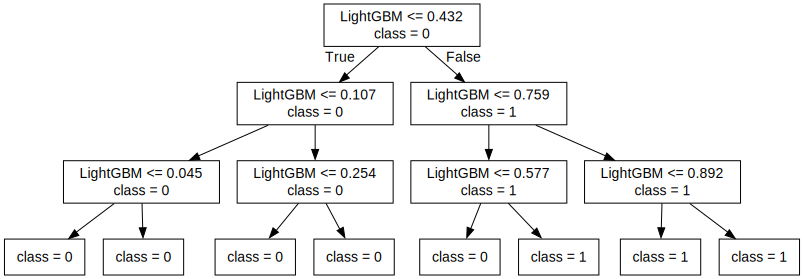

In [57]:
display_tree(list(classifiers_nocat.keys()), stacking_model_tree.final_estimator_)

<br><br>

#### An effective strategy

- **Randomly generate** a bunch of models with **different hyperparameter** configurations, 
- and then **stack all the models**.

<br>

#### Advantage and Disadvantage

- What is an advantage of ensembling multiple models as opposed to just choosing one of them?
    - You may get a **better score**.
- What is an disadvantage of ensembling multiple models as opposed to just choosing one of them?
    - **Slower**, more **code maintenance** issues.

## Summary 

- You have a number of models in your toolbox now.  
- Ensembles are usually pretty effective.
  - Tree-based classifiers are particularly popular and effective on a wide range of problems. 
  - But they trade off code complexity and speed for prediction accuracy.
  - Don't forget that hyperparameter optimization multiplies the slowness of the code!
- Stacking is a bit slower than voting, but generally higher accuracy.
  - As a bonus, you get to see the coefficients for each base classifier.
- All the above models have equivalent regression models.   

#### Relevant papers

- [Fernandez-Delgado et al. 2014](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf) compared 179 classifiers on 121 datasets:
    - First best class of methods was Random Forest and second best class of methods was (RBF) SVMs.

- If you like to read original papers [here](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) is the original paper on Random Forests by Leo Breiman. 